## Shor's Algorithm

Shor's algorithm is a famous algorithm developed by Peter Shor in 1994 for factorising integers in log N time. It is a big focus of modern research $$$, because if you can factorise large numbers quickly then you can break most public-key encryption schemes like RSA.

The algorithm relies on finding the period of a number in modulo N; the efficiency of the Quantum Fourier Transform; and, most crucially, an ideal Quantum Computer with minimal noise and decoherence.

Shor's algorithm, for all intensive purposes, is $O\big((log N)^3)$, where as classical computers take $O\Big(\exp\big((\log N)^{1/3} (\log \log N)^{2/3}\big)\Big)$. I think this motivates taking a look at the algorithm.

Shor's groundbreaking paper can be found here: https://arxiv.org/abs/quant-ph/9508027

In [2]:
import os
import sys
import numpy as np
import math
from fractions import Fraction
from dotenv import load_dotenv
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import (SamplerV2 as Sampler)
from qiskit.primitives import (BackendSamplerV2)
from requests.packages import target

In [4]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

In [44]:
# Connect to least busy backend.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ibmq_connect import ibmq_connect_least_busy
backend = ibmq_connect_least_busy(API_TOKEN, CRN)

qiskit_runtime_service._discover_account:WARNING:2025-11-17 13:53:13,072: Loading account with the given token. A saved account will not be used.


Name: ibm_fez
Version: 2
No. of qubits: 156



## 1. Overview of the Algorithm

### 1.1 Algorithm:
Shor's algorithm is split into two parts: that which can be done on a classical computer, and that needed to be done on a Quantum Computer for speed-up. Without going into too much of the maths, factoring an integer N looks like:

CLASSICAL STEPS: Find integer coprime to N.
   - 1. Pick a random integer a where 1 < a < N.
   - 2. Compute K = GCD(a, N) using Euclidean Algorithm (which is O(log n)).
   - 3. If K $\neq$ 1 then K is a factor of N --> break.

QUANTUM STEP: Find the period of that coprime number in modulo N.
   - 4. Find quantum period r, which is the smallest integer that solves $a^r$ = 1 mod N.

CLASSICAL STEPS: Use period to construct factors of N.
   - 5. If r is odd, back to step 1.
   - 6. If $a^{r/2} = -1 \text{ mod } N$. back to step 1.
   - 7. Otherwise, Both GCD($a^{r/2} + 1, N) \text{ and } $GCD$(a^{r/2} - 1, N)$ are non-trivial factors of $N$.

As to why the last steps work, we have that $(a^{r/2} + 1)(a^{r/2} - 1) = a^{r} - 1 \equiv 0$ mod $N.$

### 1.2 Period Finding:

A periodic function looks like:
$$
f(x) \equiv a^x \text{ mod } N
$$
We would like to know the period r $>0$, the smallest integer that solves
$$
a^r \text{ mod } N \equiv 1
$$
This is the part that Shor's algorithm actually solves. The solution is to use a phase estimation on the unitary operator:
$$
U |x\rangle \equiv |ax \text{ mod } N \rangle
$$
I spent a while looking at walls of eigenstates to try and understand this, but breaking it down helps: starting at $|1\rangle$, how many times do we have to apply U to get $|1\rangle$ again? I.e. what x gives $U^x |1\rangle = |1\rangle$, where U corresponds to the gate that multiplies the register by a ( mod N ). Being able to evaluate all $U^x$ at once gives a significant speed-up over classical registers.

If we look at N=15 (which IBM proved can be calculated in 2001) then a could be any of a = [2, 4, 7, 8, 11, 13] since GCD(a, 15) = 1. Picking a = 2 gives :
$$
2^1 \equiv 2 \text{ mod } 15
$$
$$
2^2 \equiv 4 \text{ mod } 15
$$
$$
2^3 \equiv 8 \text{ mod } 15
$$
$$
2^4 = 16 \equiv 1 \text{ mod } 15
$$
Therefore r = 4. Check $2^{4/2} = 4 \neq -1$ mod $15$ so conditions satisfied, then:
$$
    GCD(2^{r/2} - 1, 15) = GCD(3, 15) = 5
$$
$$
    GCD(2^{r/2} + 1, 15) = GCD(5, 15) = 3
$$
The goal is to superposition x=1,2,3,4,... and evaluate $a^x$ mod $N$ in parallel. It is generally advised to use double the number of qubits to describe x, as to describe N. 4 qubits are needed for N=15, so m=8 qubits will be needed for x, giving a range of periods from 1 to 255. This represents the Unitary Matrices $U^1, ..., U^{255}$.

### 1.3 Quantum Circuit
Shor's circuit for the quantum steps works in three parts:
   - Build target register corresponding to $|1\rangle$. Also build a counting register for state $|x\rangle$, and put into equal super position $|+\rangle$.
   - Apply the modular exponentiation unitary $|x\rangle|1\rangle \rightarrow |x\rangle|a^x \text{ mod } N \rangle$
   - Apply an Inverse Quantum Fourier Transform (QFT) on the counting register to extract (though not directly) the period r, from possible x values. Measuring after this gives us a value that can be used to classically recover r. More on this later, one step at a time.

I managed to implement the Quantum Fourier Transform in **`qft.py`** - more information on how it transforms the phase informaiton can be found in **`4-QFT.ipynb`**.

## 2. Basic Implementation
To implement I will import my dependencies from **`qft.py`**, and the in-built UnitaryGate package from qiskit, which constructs a Unitary Gate from any Unitary Matrix https://quantum.cloud.ibm.com/docs/en/api/qiskit/1.0/qiskit.circuit.library.UnitaryGate.

I will work on the example N = 15, and pick a = 2, as it is coprime to 15 and the period works. Thats steps 1,2 and 3 out of the way.

In [6]:
from qiskit.circuit.library import UnitaryGate # import Unitary Gate and Quantum Fourier Transform
from qft import *

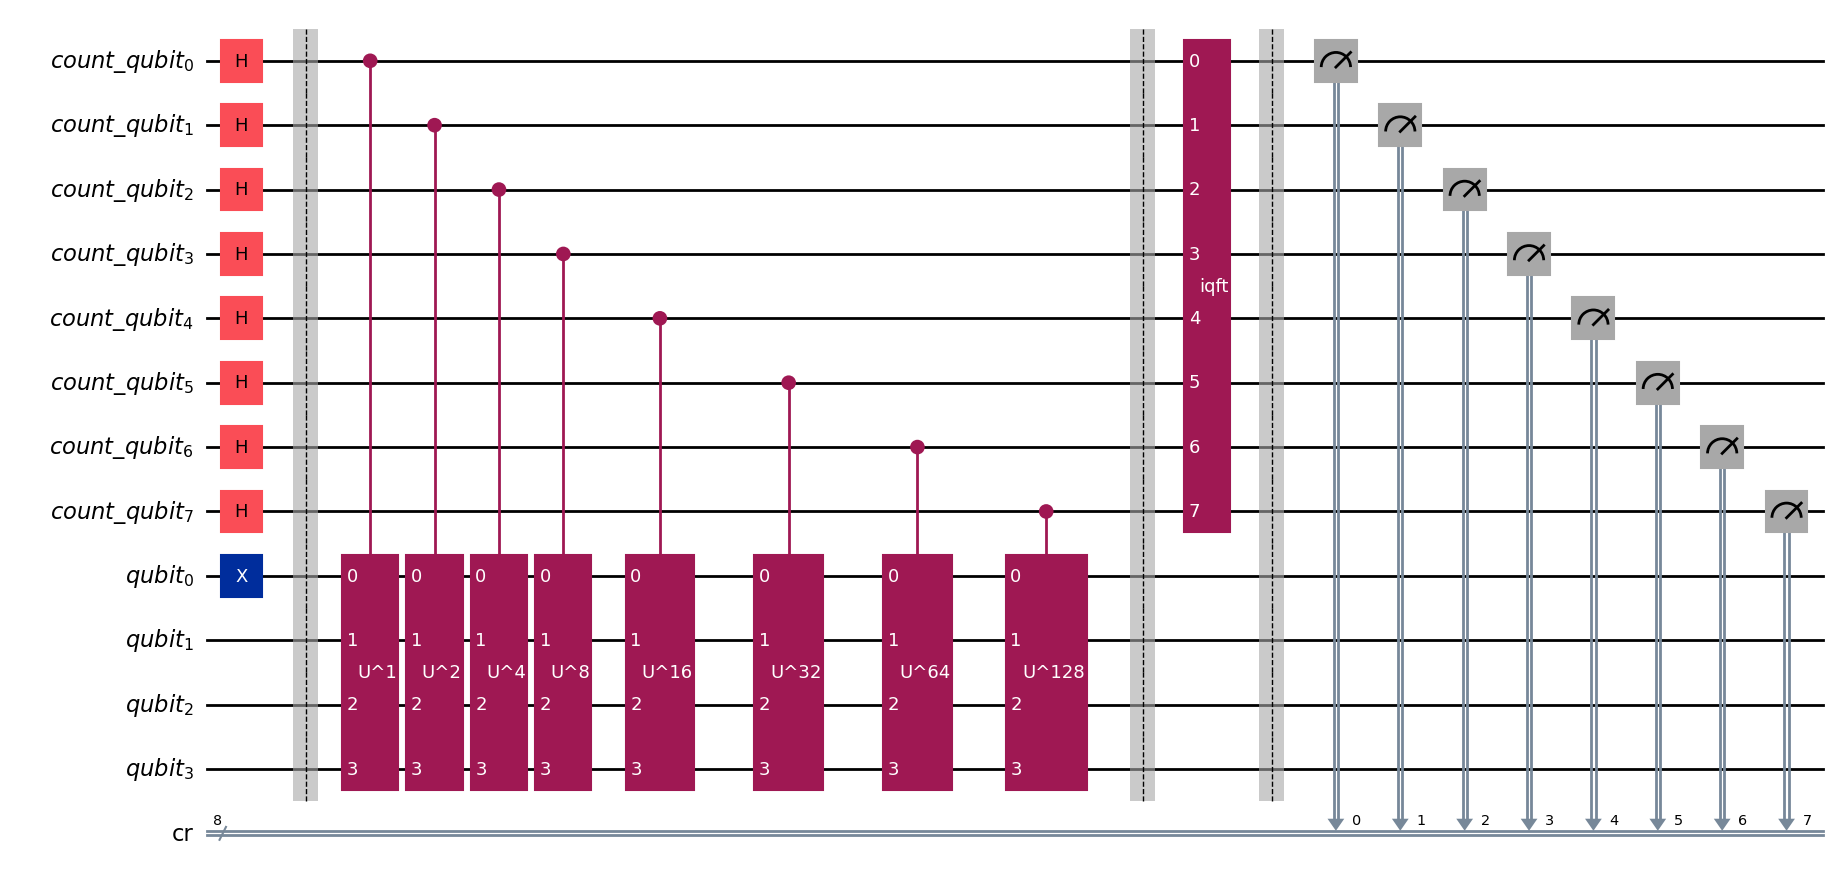

In [79]:
# ------ Parameters ------

_N: int = 15
_a_list: list[int] = [2, 4, 7, 8, 11, 13, 14]
_a = 2

_num_qubits: int = _N.bit_length() # (n) number of qubits to represent N
_num_counting_qubits: int = 2*_num_qubits   # counting register. Used to store phase information encoding r.

def shors_circuit(a, N, num_qubits, num_counting_qubits):
    """
    Builds a quantum circuit for the quantum part of Shor's algorithm.

    Parameters
    ----------
    a : int
        An integer coprime to N, for which we want to find the period of a^x mod N.
    N : int
        The integer to be factorized.
    num_qubits : int
        Number of qubits in the target register (used to store |1> initially).
    num_counting_qubits : int
        Number of qubits in the counting register (used to estimate the period).

    Returns
    -------
    QuantumCircuit
        A Qiskit QuantumCircuit object for Shor's algorithm.
    """

    # ------ Build Register ------
    qr_counting = QuantumRegister(num_counting_qubits, 'count_qubit') # register for counting
    qr_target = QuantumRegister(num_qubits, 'qubit') # register for target state
    cr = ClassicalRegister(num_counting_qubits, 'cr') # classical register for measuring counting qubits
    qc = QuantumCircuit(qr_counting, qr_target, cr)

    # set counting register into superposition
    qc.h(range(num_counting_qubits))

    # set target register to |1>
    qc.x(num_counting_qubits)

    qc.barrier()


    # ------ Build unitary matrix. ------
    dim = 2**num_qubits
    U = np.zeros((dim, dim), dtype=complex)

    # U acts as |x> -> |a*x mod N> for 0 <= x < 2^n.
    for x in range(dim):
        if x < N:
            u = (a * x) % N
        else:
            # for states outside [0,N-1],leave them unchanged
            u = x
        U[u, x] = 1.0


    # ------ Apply all Unitary Gates to each counting qubit ------
    for j in range(num_counting_qubits):
        # set power, so that we have U^0, U^1, U^2, U^4,... applied to each counting qubit.
        power = 2**j

        U_power = np.linalg.matrix_power(U, power) # calculate U^x
        U_gate = UnitaryGate(U_power, label=f"U^{power}") # build Unitary Gate from U^x
        controlled_U_gate = U_gate.control()  # controlled on 1 qubit

        # add gate to circuit: counting qubit j acts as the control qubit, while the gate acts on the target qubits
        qc.append(controlled_U_gate, [j] + [num_counting_qubits + i for i in range(num_qubits)])

    qc.barrier()


    # ------ Apply inverse QFT on counting register ------
    inv_qft = QuantumCircuit(qr_counting, name='iqft')
    inv_qft = qft(inv_qft, num_counting_qubits, inverse=True, swap_endian=True)
    qc.append(inv_qft, list(range(num_counting_qubits)))
    qc.barrier()


    # ------ Measure Counting Qubits -------
    for i in range(num_counting_qubits):
        qc.measure(i, i)

    return qc

qc = shors_circuit(_a, _N, _num_qubits, _num_counting_qubits)
qc.draw('mpl')

I think this helps visualise what is going on. It gives a good idea of how we apply all powers $a^x$. The counting bits acting as controls let us build all the unitary gates. For example, state x = 10100100 gives $U^{1}U^{4}U^{32} = U^{37}$, corresponding to $a^{37}$ mod N. Nice!

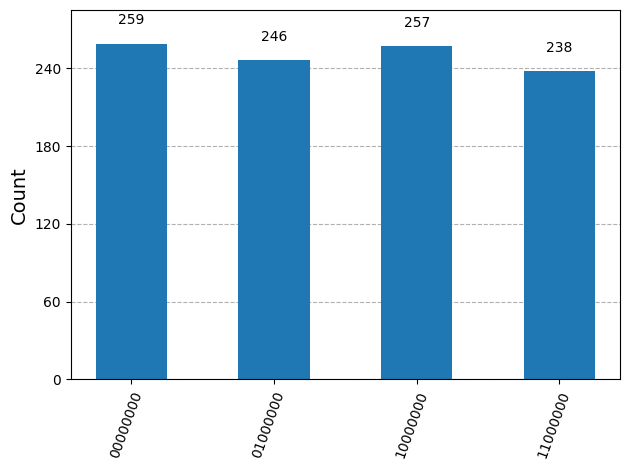

In [80]:
# ------ Run Simulation on Backend ------
def simulate_backend(qc):
    """ Runs quantum circuit on simulated backend and returns counts. """
    backend = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, backend)
    job = backend.run(qc, shots=1000)
    result = job.result().get_counts()
    return result

_result = simulate_backend(qc)
plot_histogram(_result)

Great, some results that I am unable to interpret. It is easy to read off that these bits correspond to 0, 1, 2 and 3. Shor's algorithm guarantees (with high probability) that:
$$
\frac{x}{2^{m}} \approx \frac{k}{r}
$$
where m is the number of counting bits, and k is some integer unknown to us. Important note: the standard Quantum Fourier Transform on n-qubits ends up reversing the order of the qubits. I built a function to reverse this with `'swap_endian=True'`.

We can read off the results x = 0, 64, 128, 192. Disregard 0, so k/r = 1/4, 1/2, 3/4. Since k is an integer, we get r = 4, 2, 4. The following is a generalisation of this: 

In [63]:
def find_r(_x, m):
    """ Find period by continued fractions """
    frac = Fraction(_x, 2**m).limit_denominator() # find the simplest fraction closest to C/2^m
    r = frac.denominator
    return r

def get_period(counts, a, N, num_counting_qubits):
    """ Get period from set of phase estimations """

    # -- convert measurements to integers __
    vals = []
    for bitstring, _ in counts.items():
        x = int(bitstring, 2)
        if x != 0: vals.append(x)

    # -- get candidate periods --
    r_candidates = [find_r(_x, num_counting_qubits) for _x in vals]

    # -- generate periods and check against algorithm constraints. --
    r_vals = [r for r in r_candidates if (pow(a, r, N) == 1) and (r%2 == 0) and (pow(a, int(r/2), N) != 1)]
    period = min(r_vals)

    print("Raw x values:", vals)
    print("Candidate r:", r_candidates)
    print("Valid r:", r_vals)
    print("Period:", period)

    return period

_r = get_period(_result, _a, _N, _num_counting_qubits)

Raw x values: [192, 128, 64]
Candidate r: [4, 2, 4]
Valid r: [4, 4]
Period: 4


In [81]:
def get_factors(a, r, N):
    """ Get factors from a, r and N """
    f1 = math.gcd(pow(a, r//2, N) + 1, N)
    f2 = math.gcd(pow(a, r//2, N) - 1, N)
    return f1, f2

_f1, _f2 = get_factors(_a, _r, _N)
print('Factors:', _f1, _f2)

Factors: 5 3


## 3. General Implementation
Here I implement the classical part of Shor's algorithm alongside the quantum park. I randomly pick a and check if coprime, then run Shor's circuit and check the period.

In [84]:
import random

def run_shors(N, num_shots: int = 1000, on_hardware: bool = False, a_list: list[int] = []):
    """
    Run Shor's algorithm to factor an integer N.

    Parameters
    ----------
    N : int. Integer to factor.
    num_shots : int, optional. Measurement shots per circuit execution. Default is 1000.
    on_hardware : bool, optional. If True, run on a quantum device; otherwise use a simulator.
    a_list : list[int], optional. Candidate bases ``a``. If empty, defaults to ``range(2, N)``.

    Returns
    -------
    f1 : int. First factor of N.
    f2 : int. Second factor of N.
    counts : dict. Measurement counts from the successful order-finding run. Empty if N is prime.
    """

    if not a_list: a_list = list(range(2, N)) # generate list of candidate values for a if non supplied
    num_qubits: int = N.bit_length() # (n) number of qubits to represent N
    num_counting_qubits: int = 2*num_qubits   # counting register. Used to store phase information encoding r.

    while True:
        # run out of candidate a's, break from loop
        if len(a_list) == 0: break

        # get random candidate a from list
        a = a_list.pop(random.randint(0, len(a_list) - 1))
        print('Trying a := ', a)

        # check if a coprime to N. If not, try new a.
        if math.gcd(a, N) == 1:

            # Generate Circuit
            circuit = shors_circuit(a, N, num_qubits, num_counting_qubits)

            # Transpile
            backend_target = backend.target
            pm = generate_preset_pass_manager(target=backend_target, optimization_level=3)
            qc_isa = pm.run(circuit)

            if on_hardware:
                # Run Algorithm on Hardware
                sampler = Sampler(mode=backend)
                pubs = [qc_isa]
                job = sampler.run(pubs, shots=num_shots)
                res = job.result()
            else:
                # Run sample on quantum simulator of backend
                backend_sim = AerSimulator.from_backend(backend)
                sampler_sim = BackendSamplerV2(backend=backend_sim)
                job = sampler_sim.run([[qc_isa]], shots=num_shots)
                res = job.result()

            # # get data in readable format
            counts = res[0].data.cr.get_counts()

            # get period
            period = get_period(counts, a, N, num_counting_qubits)

            if pow(a, period//2, N) != -1:
                print('a: ', a)
                f1, f2 = get_factors(a, period, N)
                print('Factors:', f1, f2)
                return f1, f2, counts

        else: print(f'{a} not coprime to {N}')

    print('N has no coprime integers, therefore N is prime')
    return N, 1, {}

Trying a :=  2
Raw x values: [64, 192, 18, 128, 176, 32, 132, 196, 178, 8, 66, 144, 160, 16, 248, 1, 127, 40, 194, 164, 96, 254, 2, 41, 65, 228, 80, 224, 193, 129, 208, 4, 168, 116, 104, 112, 61, 136, 200, 251, 130, 72, 137, 240, 252, 244, 68, 36, 161, 188, 33, 124, 249, 184, 56, 225, 52, 100, 120, 202, 48, 20, 42, 148, 97, 34, 75, 70, 122, 50]
Candidate r: [4, 4, 128, 2, 16, 8, 64, 64, 128, 32, 128, 16, 8, 16, 32, 256, 256, 32, 128, 64, 8, 128, 128, 256, 256, 64, 16, 8, 256, 256, 16, 64, 32, 64, 32, 16, 256, 32, 32, 256, 128, 32, 256, 16, 64, 64, 64, 64, 256, 64, 256, 64, 256, 32, 32, 256, 64, 64, 32, 128, 16, 64, 128, 64, 256, 128, 256, 128, 128, 128]
Valid r: [4, 4]
Period: 4
a:  2
period:  4
Factors: 5 3


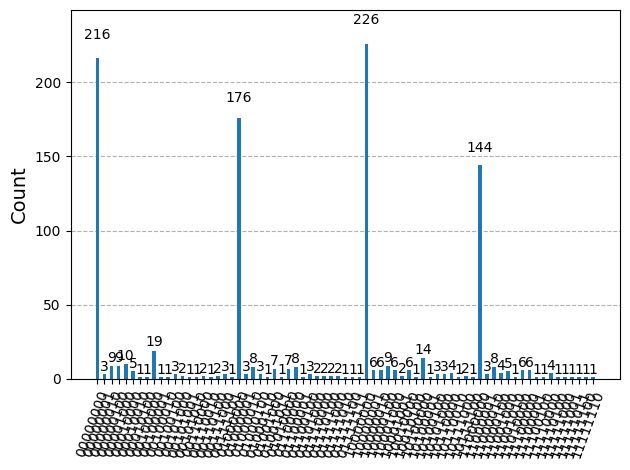

In [83]:
# test on simulated version of backend
_f1, _f2, _counts = run_shors(_N, num_shots=1000, on_hardware=False, a_list = [_a])
plot_histogram(_counts)

Simulated backend has a bit more noise in period finding, but nothing major, and succeeds well.

In [89]:
# # test on real backend.
# _f1, _f2, _counts = run_shors(_N, num_shots=1000, on_hardware=True, a_list = [2])

qiskit_runtime_service._discover_account:WARNING:2025-11-17 14:58:10,252: Loading account with the given token. A saved account will not be used.


Raw x values: [181, 15, 22, 41, 98, 168, 111, 67, 215, 108, 245, 254, 203, 180, 110, 242, 71, 251, 224, 17, 241, 143, 178, 239, 193, 34, 94, 18, 155, 209, 195, 24, 212, 188, 216, 130, 135, 113, 201, 30, 8, 189, 202, 138, 25, 95, 12, 122, 47, 43, 59, 19, 40, 206, 146, 123, 250, 120, 61, 64, 20, 179, 246, 154, 1, 5, 204, 145, 199, 118, 52, 161, 75, 106, 89, 85, 210, 105, 26, 140, 174, 226, 244, 124, 66, 134, 167, 79, 144, 100, 211, 217, 207, 46, 234, 166, 9, 39, 129, 117, 10, 38, 68, 192, 86, 101, 190, 23, 54, 128, 83, 231, 162, 3, 182, 91, 127, 173, 131, 233, 153, 60, 115, 76, 29, 97, 2, 44, 70, 133, 96, 142, 252, 240, 16, 33, 213, 51, 88, 222, 184, 107, 84, 205, 80, 171, 169, 90, 13, 27, 93, 147, 7, 121, 114, 42, 170, 87, 55, 78, 65, 228, 74, 227, 150, 229, 185, 160, 247, 159, 28, 194, 126, 99, 230, 152, 186, 50, 73, 45, 6, 104, 81, 21, 103, 119, 200, 112, 176, 225, 141, 164, 236, 69, 32, 220, 35, 136, 14, 56, 58, 36, 137, 175, 219, 92, 63, 149, 237, 238, 4, 37, 156, 214, 11, 197, 102,

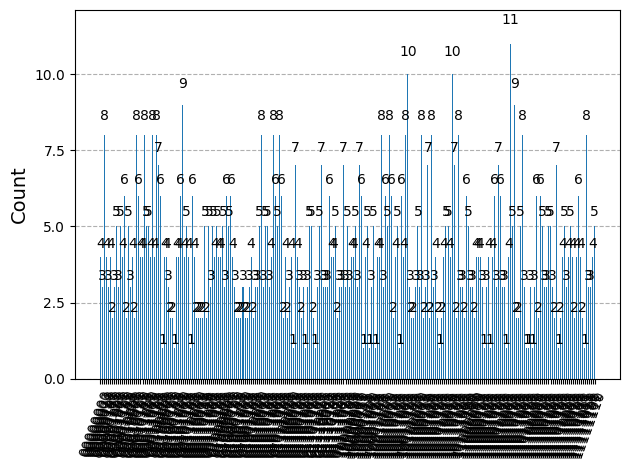

In [91]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    token = API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d4dj89heg65s738lhpcg')
job_result = job.result()

# get data in readable format
counts = job_result[0].data.cr.get_counts()

# get period
period = get_period(counts)

if pow(2, period//2, _N) != -1:
    print('a: ', _a)
    f1, f2 = get_factors(_a, period, _N)
    print('Factors:', f1, f2)

plot_histogram(counts)

Real backend has a lot of noise in period finding, but still accurately finds the factors. From continued fractions, all the x-candidates correspond to periods of 2, 4, 8, 16, 32, 64, 128, 256 so we accurately find period 4 and the factors.

## 4. Testing on other integers: N=21.

In [92]:
# test on real backend, try N = 21 and no prior knowledge of coprime integers.
_f1, _f2, _counts = run_shors(21, num_shots=1000, on_hardware=True)

Trying a :=  17
Raw x values: [992, 726, 304, 848, 521, 267, 257, 278, 353, 550, 1009, 84, 803, 525, 266, 469, 402, 259, 987, 384, 576, 513, 310, 240, 614, 439, 816, 322, 192, 320, 860, 560, 256, 897, 407, 66, 819, 326, 773, 679, 824, 289, 91, 873, 328, 887, 760, 542, 299, 830, 674, 176, 864, 804, 358, 64, 705, 65, 820, 780, 879, 624, 782, 44, 208, 288, 876, 769, 1, 835, 166, 118, 787, 293, 419, 977, 767, 592, 334, 564, 582, 154, 802, 281, 448, 729, 55, 297, 596, 659, 672, 360, 793, 613, 147, 620, 99, 1022, 784, 738, 538, 508, 4, 24, 97, 468, 22, 839, 597, 273, 654, 842, 609, 577, 49, 585, 854, 739, 59, 128, 90, 290, 265, 629, 591, 519, 961, 544, 668, 380, 158, 583, 74, 648, 98, 779, 928, 92, 976, 948, 250, 282, 321, 833, 52, 800, 941, 867, 851, 354, 785, 87, 37, 850, 539, 102, 347, 706, 799, 781, 603, 270, 249, 745, 716, 111, 85, 34, 834, 618, 403, 548, 778, 397, 344, 1014, 16, 243, 308, 676, 261, 578, 593, 268, 312, 888, 378, 294, 843, 621, 505, 566, 774, 846, 470, 277, 553, 357, 557

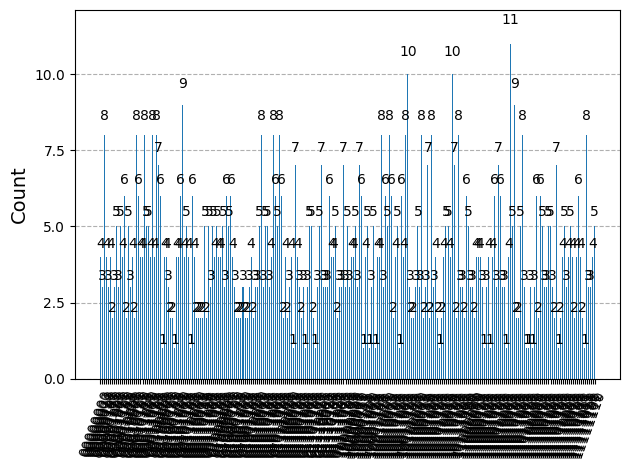

In [93]:
plot_histogram(counts)

Finds factors 1 and 3, from which we can recover 7. Not sure why it is giving factor of 1. Needs some more work. 